# How to calculate and plot wind speed using MERRA-2 wind component data using Python

***

## Overview:

This tutorial demonstrates how to calculate and plot hourly wind speed using the northward and eastward wind component variables with MERRA-2 data using Python.

## Prerequisites:

This notebook was written in Python 3.9 and requires these libraries and files:
- [Matplotlib](http://matplotlib.org/)
- [Cartopy](https://scitools.org.uk/cartopy/docs/latest/)
- [netCDF4](http://unidata.github.io/netcdf4-python/)
- [NumPy](http://www.numpy.org/)
- [earthaccess](https://earthaccess.readthedocs.io/en/latest/)
- Example data set: https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_V5.12.4/summary
- Example data: https://data.gesdisc.earthdata.nasa.gov/data/MERRA2/M2T1NXSLV.5.12.4/2010/06/MERRA2_300.tavg1_2d_slv_Nx.20100601.nc4


<img src ="https://disc.gsfc.nasa.gov/media/image/4460b42cb7c841fa9bbd74c5c26cad67/MERRA2_2m_ws.png" title="Image1" width=600 height=400 />

**Figure 1.** MERRA-2 windspeed calculated from 2-meter northward and eastward wind component variables. 

***

<img src ="https://disc.gsfc.nasa.gov/media/image/acd5ca3e8eb14f84aa58e9f584b99e2f/MERRA2_2m_wsVECTORS.png" title="Image2" width=600 />

**Figure 2.** MERRA-2 windspeed and direction calculated from 2-meter northward and eastward wind component variables.

## Procedure:

Wind speeds can be calculated using MERRA-2 eastward and northward wind components. Before we calculate wind speed we will define the wind components, also referred to as vectors.

Eastward and northward wind vectors are represented by the variables “u” and “v” respectively. MERRA-2 u wind is parallel to the x-axis (i.e. longitude). A positive u wind comes from the west, and a negative u wind comes from the east. MERRA-2 v wind is parallel to the y-axis (i.e. latitude). A positive v wind comes from the south, and a negative v wind comes from the north. These variable long names typically contain "eastward wind" or "northward wind" at a given pressure or height. Example long name: 2-meter eastward wind.

Given the u and v wind components, we can calculate the wind speed using the Pythagorean Theorem:

_Wind Speed_ = $ \sqrt{u^2+v^2} $

<img src ="https://disc.gsfc.nasa.gov/api/images/windspeed_diagram/file" title="Image3" width="500"/>

To find the direction of wind speed, use arctan(v/u) when u is not equal to zero. You also must adjust for what quadrant you are in based on the sign of u and v. Most scripting languages (Python, matlab, IDL, etc.) have an arctan2 function that will take care of these issues for you. Be careful to note whether you are working in radians or degrees when determining your direction.

**NOTE:** It is important to use the arctan2 (two-argument arctangent) function rather than the arctan (inverse tangent) function.  The arctan2 function returns the angle for the component vectors u and v on a Cartesian plane.  The arctan function returns the angle for the ratio of the component vectors (i.e. v/u) on a Cartesian plane and will have non-unique values depending upon which quadrant in which the resultant vector lies.

Most scripting languages also have packages that can compute the wind magnitudes for you. We use the "quiver" plot function that is part of the matplotlib library. The code below is a Python script that will compute and plot wind speed and direction from MERRA-2 wind vector components. We also compute the daily averaged wind speed as the variable "<font color=red>ws_daily_avg</font>".

 

**NOTE**: To compute, daily, weekly, and especially monthly averaged wind speed values, the user should use hourly north and east wind component variables to compute the hourly wind speed averages. Then use those hourly wind speed averages to compute the average daily, weekly or monthly wind speed.

### PLOT MERRA-2 WIND SPEED 
The first step is to import the required Python libraries. The netCDF4 Dataset and numpy imports allow you to read in the file and perform calculations. The matplotlib and cartopy libraries allow you to plot the data. If any of the following import commands fail, check the local Python environment and install any missing packages.

In [ ]:
from netCDF4 import Dataset
import earthaccess
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import warnings
from glob import glob
warnings.filterwarnings("ignore")

%matplotlib inline

Search for the granule using `earthaccess`

In [2]:
# Authenticate using Earthdata Login prerequisite files
auth = earthaccess.login()

# Search for the granule by DOI
results = earthaccess.search_data(
    doi='10.5067/VJAFPLI1CSIV',
    temporal=("2010-06-01", "2010-06-01"),
)

Download the granule

In [3]:
files = earthaccess.download(results, "./MERRA2_Downloads")

QUEUEING TASKS | : 100%|████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.56it/s]
PROCESSING TASKS | : 100%|███████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.04s/it]
COLLECTING RESULTS | : 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


Open the granule using `netcdf4-python`

In [18]:
# Get file name
fn = glob("./MERRA2_Downloads/*.nc4")[0]

# Open datatset
data = Dataset(fn, mode='r')

Run the following cell to see the MERRA-2 metadata. This line will print attribute and variable information. From the 'variables(dimensions)' list, choose which variable(s) to read in below:

In [19]:
print(data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    History: Original file generated: Sat Apr  4 12:17:20 2015 GMT
    Comment: GMAO filename: d5124_m2_jan00.tavg1_2d_slv_Nx.20100601.nc4
    Filename: MERRA2_300.tavg1_2d_slv_Nx.20100601.nc4
    Conventions: CF-1
    Institution: NASA Global Modeling and Assimilation Office
    References: http://gmao.gsfc.nasa.gov
    Format: NetCDF-4/HDF-5
    SpatialCoverage: global
    VersionID: 5.12.4
    TemporalRange: 1980-01-01 -> 2016-12-31
    identifier_product_doi_authority: http://dx.doi.org/
    ShortName: M2T1NXSLV
    GranuleID: MERRA2_300.tavg1_2d_slv_Nx.20100601.nc4
    ProductionDateTime: Original file generated: Sat Apr  4 12:17:20 2015 GMT
    LongName: MERRA2 tavg1_2d_slv_Nx: 2d,1-Hourly,Time-Averaged,Single-Level,Assimilation,Single-Level Diagnostics
    Title: MERRA2 tavg1_2d_slv_Nx: 2d,1-Hourly,Time-Averaged,Single-Level,Assimilation,Single-Level Diagnostics
    SouthernmostLatitude: -90.0


Read in variables:

In [20]:
# longitude and latitude
lons = data.variables['lon']
lats = data.variables['lat']
lon, lat = np.meshgrid(lons, lats)
# 2-meter eastward wind m/s
U2M = data.variables['U2M']
# 2-meter northward wind m/s
V2M = data.variables['V2M']

Replace \_FillValues with NaNs:

In [21]:
U2M_nans = U2M[:]
V2M_nans = V2M[:]
_FillValueU2M = U2M._FillValue
_FillValueV2M = V2M._FillValue
U2M_nans[U2M_nans == _FillValueU2M] = np.nan
V2M_nans[V2M_nans == _FillValueV2M] = np.nan

Calculate wind speed:

In [22]:
ws = np.sqrt(U2M_nans**2+V2M_nans**2)

Calculate wind direction in radians:

In [23]:
ws_direction = np.arctan2(V2M_nans,U2M_nans)

**NOTE:** The MERRA-2 file contains hourly data for 24 hours (t=24). To get the daily mean values, take the average along the time dimension. Calculate daily average wind speed and daily average wind direction (in radians):

In [24]:
ws_daily_avg = np.nanmean(ws, axis=0)

**NOTE:** To calculate the daily average wind direction correctly, it is important to use the 'vector average' as atan2(&lt;v&gt;,&lt;u&gt;), where &lt;v&gt; and &lt;u&gt; are the daily averages of the component vectors. Do not average the individual wind direction angles. This avoids a situation where averaging wind direction values 1 and 359 would give 180 instead of the desired 0. 

In [25]:
U2M_daily_avg = np.nanmean(U2M_nans, axis=0)
V2M_daily_avg = np.nanmean(V2M_nans, axis=0)
ws_daily_avg_direction = np.arctan2(V2M_daily_avg, U2M_daily_avg)

#### Plot global MERRA-2 wind speed 

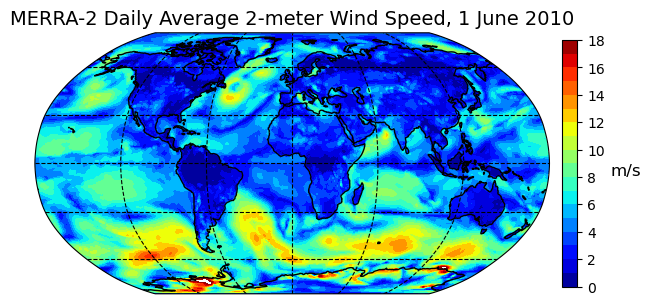

In [26]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines(resolution="110m",linewidth=1)
ax.gridlines(linestyle='--',color='black')

# Plot windspeed:
# Set contour levels, then draw the plot and a colorbar
clevs = np.arange(0,19,1)
plt.contourf(lon, lat, ws_daily_avg, clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
plt.title('MERRA-2 Daily Average 2-meter Wind Speed, 1 June 2010', size=14)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('m/s',size=12,rotation=0,labelpad=15)
cb.ax.tick_params(labelsize=10)

Save the figure as a PNG:

In [11]:
fig.savefig('MERRA2_2m_ws.png', format='png', dpi=120)

#### Plot wind speed with direction 
The filled contours show the wind speed. The "quiver" function is used to overlay arrows to show the wind direction. The length of the arrows is determined by the wind speed. 

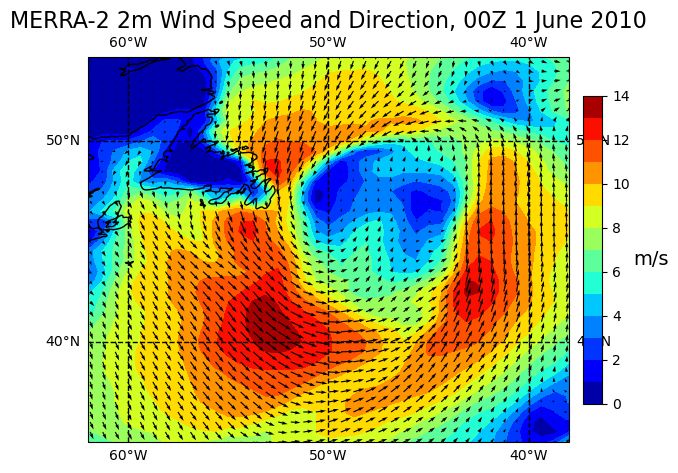

In [27]:
# Set the figure size, projection, and extent
fig = plt.figure(figsize=(9,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-62,-38,35,54])  
ax.coastlines(resolution="50m",linewidth=1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = True
gl.xlocator = mticker.FixedLocator([-65,-60,-50,-40,-30])
gl.ylocator = mticker.FixedLocator([30,40,50,60])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':10, 'color':'black'}
gl.ylabel_style = {'size':10, 'color':'black'}

# Plot windspeed
clevs = np.arange(0,14.5,1)
plt.contourf(lon, lat, ws[0,:,:], clevs, transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
plt.title('MERRA-2 2m Wind Speed and Direction, 00Z 1 June 2010', size=16)
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.02, aspect=16, shrink=0.8)
cb.set_label('m/s',size=14,rotation=0,labelpad=15)
cb.ax.tick_params(labelsize=10)
# Overlay wind vectors
qv = plt.quiver(lon, lat, U2M_nans[0,:,:], V2M_nans[0,:,:], scale=420, color='k')

Save the figure as a PNG:

In [13]:
fig.savefig('MERRA2_2m_wsVECTORS.png', format='png', dpi=120)

<font size="1">THE SUBJECT FILE IS PROVIDED "AS IS" WITHOUT ANY WARRANTY OF ANY KIND, EITHER EXPRESSED, IMPLIED, OR STATUTORY, INCLUDING, BUT NOT LIMITED TO, ANY WARRANTY THAT THE SUBJECT FILE WILL CONFORM TO SPECIFICATIONS, ANY IMPLIED WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE, OR FREEDOM FROM INFRINGEMENT, ANY WARRANTY THAT THE SUBJECT FILE WILL BE ERROR FREE, OR ANY WARRANTY THAT DOCUMENTATION, IF PROVIDED, WILL CONFORM TO THE SUBJECT FILE. THIS AGREEMENT DOES NOT, IN ANY MANNER, CONSTITUTE AN ENDORSEMENT BY GOVERNMENT AGENCY OR ANY PRIOR RECIPIENT OF ANY RESULTS, RESULTING DESIGNS, HARDWARE, SOFTWARE PRODUCTS OR ANY OTHER APPLICATIONS RESULTING FROM USE OF THE SUBJECT FILE. FURTHER, GOVERNMENT AGENCY DISCLAIMS ALL WARRANTIES AND LIABILITIES REGARDING THIRD-PARTY SOFTWARE, IF PRESENT IN THE SUBJECT FILE, AND DISTRIBUTES IT "AS IS."